In [1]:
#!pip install langdetect
#!pip install scattertext
#!pip install spacy
#!pip install gensim
#!pip install pyLDAvis

In [1]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

In [2]:
sw = stopwords.words("english")

## Load Data

In [3]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


## Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: separate sentences, remove URLs, non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [4]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [5]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [6]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [7]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

In [8]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-8-1762eb734427>:12: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
<ipython-input-8-1762eb734427>:13: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs


In [9]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [10]:
# drop salary range variable 
del df['salary_range']

## EDA

In [11]:
df.fraudulent = pd.to_numeric(df.fraudulent)

__Bar Plots of Metadata Frequency in Fraudulent Posts__

In [12]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

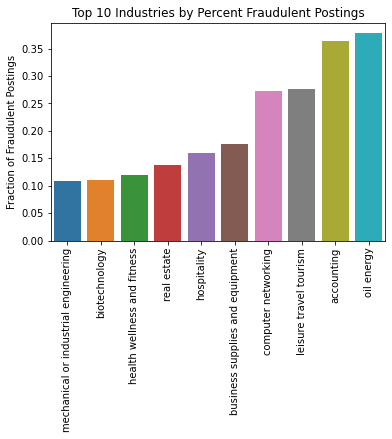

In [13]:
bar_plt('industry', 'Industries')

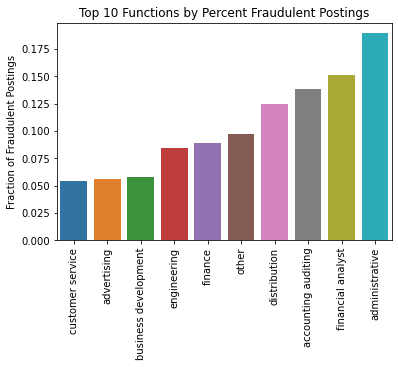

In [14]:
bar_plt('function', 'Functions')

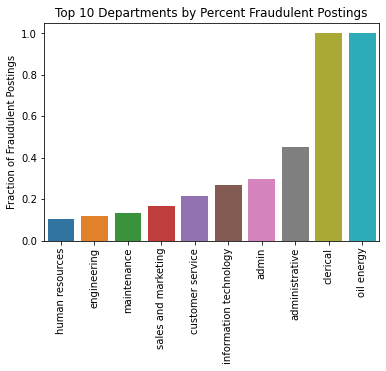

In [15]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

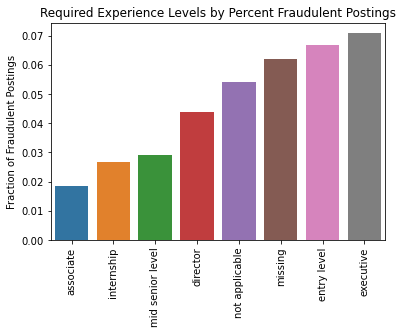

In [16]:
bar_plt('required_experience', 'Required Experience Levels')

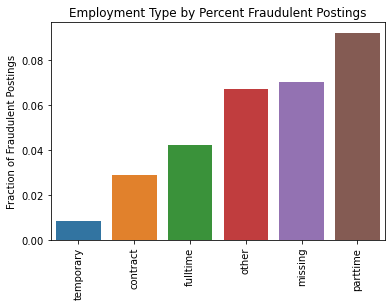

In [17]:
bar_plt('employment_type', 'Employment Type')

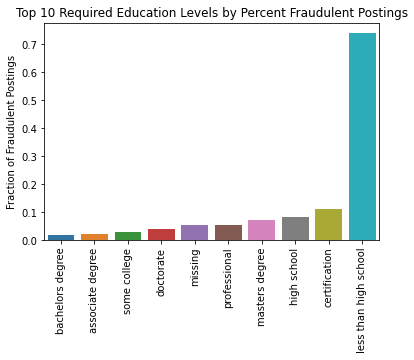

In [18]:
bar_plt('education_bin', 'Required Education Levels')

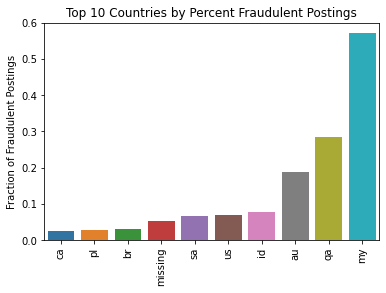

In [19]:
bar_plt('country', 'Countries')

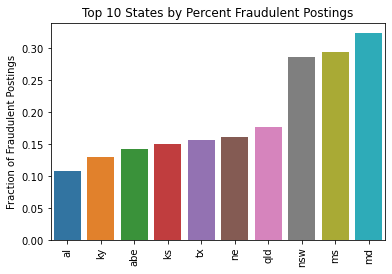

In [20]:
bar_plt('state', 'States')

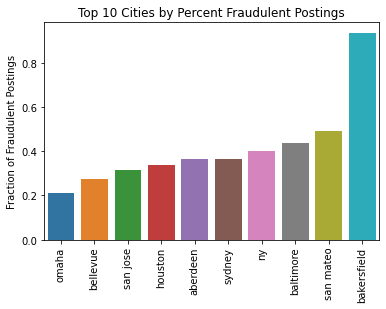

In [21]:
bar_plt('city', 'Cities')

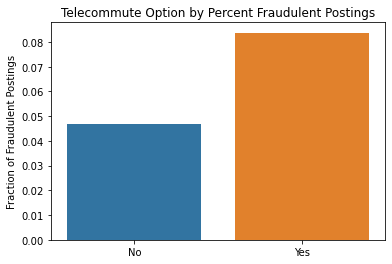

In [22]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

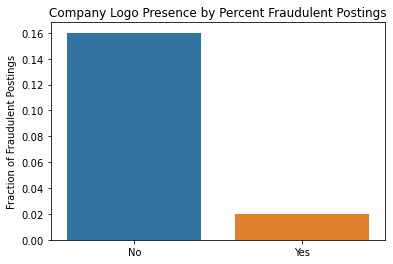

In [23]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

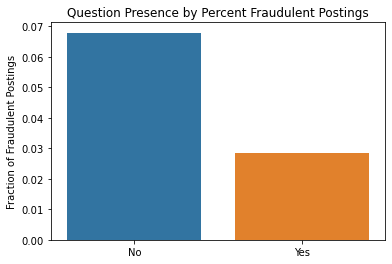

In [24]:
bar_plt('has_questions', 'Question Presence', boolean = True)

__Visualize Common Words in Fake vs Real Postings using Scattertext__   
Tokenize and remove stop words. Don't bother with lemmatization for exploratory analysis + interferes with ability to see examples using scattertext interactive html

In [12]:
nlp = spacy.load('en')

In [25]:
# run in terminal (with admina priviledges): 'py -m spacy download en'
#nltk.download('stopwords')

In [13]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [27]:
def scattertext_visualize(col):
    
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    open('./scattertext_' + col + '.html', 'w').write(html)

In [28]:
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for c in nlp_columns:
    scattertext_visualize(c)

## Topic Modeling
Sections of code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

- Combine text fields into single string
- Tokenize, remove stop words, lemmatize based on POS 
- Build term frequency corpus
- Build LDA Model
    - Tune based on topic coherence. Specificall C_V coherence
    
Topic coherence: Degree of semantic similarity between high scoring words in the topic    
Modern alternative to perplexity: how suprised a model is by new data (normalized log likelihood of held out test set)    
CV_coherence: "C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity"       
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0   
  
Parameters:
- Number of Topics
- Alpha
- Eta
    - Selecting alpha and eta with built in auto method which learns an asymetric prior from the data
     
From https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/: (assuming symmetric data)
"alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words"

In [76]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits

In [77]:
# function from
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [79]:
# tokenize
df.text = df.text.apply(lambda row: row.split(' '))
# remove stop words
df.text = df.text.apply(lambda row: [w for w in row if w not in sw])

# convert into list 
text = df.text.values.tolist()

# lemmatize and remove proper nouns 
# ex removing company names. Not important for topic modeling. 
text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [81]:
# save text string (10 minutes to run tokenization through lemmatization process)
with open('textlst.pkl', 'wb') as f:
    pickle.dump(text, f)

In [14]:
with open('textlst.pkl', 'rb') as f:
    text = pickle.load(f)

In [89]:
# term document frequency corpus for LDA
corpus_dict = corpora.Dictionary(text)
corpus = [corpus_dict.doc2bow(t) for t in text]

In [103]:
#[[(corpus_dict[id], freq) for id, freq in cp] for cp in corpus[:2]]  - human readable format

In [95]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=corpus_dict,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [160]:
# tune LDA model based on topic coherence values (maximize)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=corpus_dict,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta = 'auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [162]:
model_list, coherence_values = compute_coherence_values(dictionary=corpus_dict, corpus=corpus, texts=text, start=2, limit=20, step=1)
# 2.5 hours to run

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [175]:
np.argmax(coherence_values) # started at 2, this is position 12, so 14 topics

12

Text(0, 0.5, 'Coherence score')

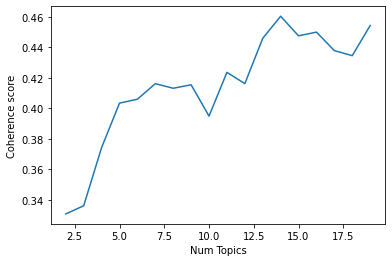

In [172]:
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# todo: change xticks to integers

In [164]:
with open('model_list.pkl', 'wb') as f:
    pickle.dump(model_list, f)

In [165]:
with open('coherence_values.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)

In [176]:
lda_model_best = model_list[12]

In [177]:
# visualize topics - still don't look separate, even if they are coherent. investigate other ways to tune. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_best, corpus, corpus_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.147780  0.009242       1        1  21.863539
5     -0.100171  0.099195       2        1  21.407784
11    -0.115843 -0.011422       3        1  11.361949
3     -0.078756 -0.016624       4        1   9.044891
9     -0.116969 -0.091898       5        1   8.559079
7     -0.105396  0.128312       6        1   6.212581
2     -0.074439 -0.085263       7        1   4.929371
4     -0.051932 -0.131645       8        1   4.208680
12    -0.090485  0.053238       9        1   3.801728
0      0.147178 -0.170967      10        1   2.290429
1      0.095673  0.048580      11        1   2.057140
8      0.077503 -0.075657      12        1   2.045141
13     0.367413 -0.104128      13        1   1.326718
10     0.194005  0.349035      14        1   0.890977, topic_info=             Term          Freq         Total Category  logprob  loglift
193      customer  33279.000000  33279.000000  Default  30.0000  30.0000
614          sale  15062.000000  15062.000000  Default  29.0000  29.0000
714           job  15750.000000  15750.000000  Default  28.0000  28.0000
89      marketing  12733.000000  12733.000000  Default  27.0000  27.0000
287       product  19139.000000  19139.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
633  successfully    464.305115   2089.907227  Topic14  -4.2914   3.2163
882         close    447.022003   2057.450195  Topic14  -4.3294   3.1940
499   competitive    442.053009   5837.107422  Topic14  -4.3405   2.1400
97          offer    430.342773  10125.977539  Topic14  -4.3674   1.5623
547      industry    320.052887   9256.216797  Topic14  -4.6635   1.3560

[944 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1214      6  0.994530     21st
151       1  0.400004  ability
151       2  0.003862  ability
151       3  0.089901  ability
151       4  0.043553  ability
...     ...       ...      ...
658       8  0.047435     year
658       9  0.044142     year
658      10  0.050585     year
658      11  0.003102     year
658      12  0.045860     year

[2186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 12, 4, 10, 8, 3, 5, 13, 1, 2, 9, 14, 11])

In [128]:
# reconstruct dataframe with metadata columns with topic probabilities 
topicdf = pd.DataFrame()
for i in range(1, 21):
    topicdf['topic' + str(i)] = 0
    
for i, row in enumerate(lda_model_best[corpus]):
    s = pd.Series(dtype = float)
    
    for j in row[0]:
        s['topic' + str(j[0])] = j[1] 
    topicdf = topicdf.append(s, ignore_index = True)

In [ ]:
# how to tune number of topics?
    # use as parameter in classification performance?
    # topic coherence as evaluation metric
        # https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0